In [315]:
#/////////////////////////////////////////////////////////////////////////////////////////////////// <imports nécessaires> ////

from arftools import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import itertools as it

#////////////////////////////////////////////////////////////////////////////////////////////////// </imports nécessaires> ////

In [316]:
#//////////////////////////////////////////////////////////////////////////////////////////// <erreur moyenne et gradient> ////

# ··· Les fonctions d'erreur concernent l'ensemble des données et sont utilisées à chaque itération d'une descente de gradient.
# ··· A chaque fonction d'erreur est associée une fonction de gradient définie qui correspond à une dérivation.

def do_shape(fonc):
    # Assure les dimensions des données d'entrée: X(n,d); W(1,d); Y(n,1).
    def shape(dataX,dataY,w,*args,**kwargs):
        dataX,dataY,w = dataX.reshape(len(dataY),-1),dataY.reshape(-1,1),w.reshape((1,-1))
        return fonc(dataX,dataY,w,*args,**kwargs)
    return shape

@do_shape
def mse(dataX,dataY,w):
    # Moyenne de l'erreur aux moindres carrés. 
    return np.mean((dataY-np.dot(dataX,w.T))**2)
@do_shape
def mseG(dataX,dataY,w):
    # Gradient moyen de ladite erreur.
    return np.mean(-2*dataX*(dataY-np.dot(dataX,w.T)),axis=0)

@do_shape
def hinge(dataX,dataY,w):
    # Moyenne de l'erreur hinge, soit le coût du perceptron max(0,−y<x.w>).
    return np.mean(np.maximum(0,-dataY*np.dot(dataX,w.T)))
@do_shape
def hingeG(dataX,dataY,w):
    # Gradient moyen de l'erreur hinge.
    mask = np.sign(np.maximum(0,-dataY*np.dot(dataX, w.T)))
    return np.mean(mask*(-dataY*dataX),axis=0)

#/////////////////////////////////////////////////////////////////////////////////////////// </erreur moyenne et gradient> ////

In [317]:
#/////////////////////////////////////////////////////////////////////////////////////////// <traitement des données usps> ////

# ··· La base USPS concerne des chiffres manuscrits qu'on affichera en niveaux de gris.

def loadUSPS(fn):
    # Lecture des données.
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def showUSPS(data,etiq=None):
    # Affichage d'une image de la base.
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")
    if etiq : plt.title("Affichage d'un élément d'étiquette"+str(etiq))
        
#////////////////////////////////////////////////////////////////////////////////////////// </traitement des données usps> ////

In [369]:
#///////////////////////////////////////////////////////////////////////////////////////// <descente de gradient linéaire> ////

# ··· La classe Linéaire implémente une descente de gradient sur son argument, une fonction de coût donnée. Elle représente 
# ··· un **perceptron** si c'est une fonction de type **hinge**, 
# ··· une **régression linéaire** si c'est une fonction de type **moindres carrés**.

class Lineaire(object):
    def __init__(self,loss=hinge,loss_g=hingeG,max_iter=1000,eps=0.01,descent="batch",batch_size=10,bias=[]):
        # :loss: fonction de coût et son gradient :loss_g:
        self.loss, self.loss_g = loss, loss_g
        # :max_iter: nombre d'itérations, de pas :eps: (learning rate).
        self.max_iter, self.eps = max_iter,eps
        # :descent: type de descente de gradient entre batch/stochastic/mini-batch
        self.descent = descent
        # :batch_size: nombre d'exemples tirés au hasard dans le cas de mini-batch
        self.batch_size = batch_size
        # :bias: le biais initial si besoin est
        self.bias = bias
        
        # allossA et allossT servent à visualiser l'évolution de l'erreur au fil des itérations.
        self.allossA , self.allossT = [], []

    def fit(self,dataX,dataY,testX=False,testY=False):
        # :testX:, :testY:, données et labels de test.
        # :dataX:, :dataY:, données et labels de train.
        # dataY doit devenir un vecteur colonne.
        # Récupérer dans N le nombre de lignes considérées,
        # et dans D le nombre de dimensions pour la régression.
        dataY = dataY.reshape(-1,1)
        N = len(dataY)
        dataX = dataX.reshape(N,-1)
        D = dataX.shape[1]
        # Initialisation des poids à donner à chaque dimension.
        # En garder une copie pour faire un historique.
        if not self.bias: self.w = np.full((1,D),0.0001) # np.ones((1,D)) # np.random.random((1,D)) 
        else: self.w = np.array(self.bias)
        # Attention, s'il y avait un biais, il fallait que la longueur de l'array corresponde bien à D.
        self.allw = np.array([self.w.reshape(-1)])
        # Lancer la régression.
        # Itérer jusqu'au butoir,
        for i in range(self.max_iter):
            # en gardant à chaque fois une trace de l'erreur sur train et test,
            if type(testX) != bool:
                self.allossA.append(self.loss(dataX, dataY, self.w))
                self.allossT.append(self.loss(testX, testY, self.w))
            # et en rafraîchissant les poids courants et l'historique global. Trois possibilités :
            if self.descent == "batch":
                #////////////////////////////////// OPTION 1 /////////////////////////////////////
                # Reprendre toute la base d’exemples pour corriger les poids w à chaque itération.
                self.w -= self.eps*self.loss_g(dataX,dataY,self.w)
            elif self.descent == "stochastic":
                #////////////////////////////////// OPTION 2 /////////////////////////////////////
                # Tirer un exemple au hasard dans la base pour corriger les poids en conséquence.
                # On travaille alors sur la base de l'élément aléatoire d'indice ind :
                ind = np.random.randint(len(dataX))
                self.w -= self.eps*self.loss_g(dataX[ind],dataY[ind],self.w)
            elif self.descent == "mini-batch":
                #////////////////////////////////// OPTION 3 /////////////////////////////////////
                # Tirer un petit sous-ensemble au hasard pour corriger les poids en conséquence.
                inds = np.random.randint(len(dataX),size=self.batch_size)
                self.w -= self.eps * self.loss_g(dataX[inds], dataY[inds], self.w)
            # Quelle que soit la méthode de calcul, ajouter les nouveaux poids à l'historique.
            self.allw = np.append(self.allw, self.w,axis=0)
        return self.w

    def predict(self,dataX):
        # Une fois les poids calculés, les utiliser pour la prédiction.
        if len(dataX.shape)==1:
            dataX = dataX.reshape(1,-1)
        return np.sign(np.dot(dataX,self.w.T)).reshape(-1)
    
    def score(self,dataX,dataY):
        # Evaluer la justesse de la régression en comparant,
        # en proportion, les prédictions aux étiquettes originales.
        return np.mean(self.predict(dataX) == dataY)

#//////////////////////////////////////////////////////////////////////////////////////// </descente de gradient linéaire> ////

In [344]:
#////////////////////////////////////////////////////////////////////////////////////////// <fonctions d'affichage utiles> ////

# ··· Rendu graphique pour une lecture facile des événements. 

mymap = 'pink'
mymap2 = 'pink'
def plotError(dataX,dataY,f,step=10):
    # Tracer la surface de la fonction d'erreur f sur un set 2D dataX.
    grid,x1list,x2list=make_grid(xmin=-4,xmax=4,ymin=-4,ymax=4)
    plt.contourf(x1list,x2list,np.array([f(dataX,dataY,w) for w in grid]).reshape(x1list.shape),25,cmap=mymap)
    plt.colorbar()
    return plt
    
def plotwTrace(dataX,dataY,f,step,allw):
    # Tracer l'évolution des ensembles de poids.
    lim = np.ceil(np.max(np.abs(allw))+1)
    grid,x1list,x2list=make_grid(xmin=-lim,xmax=lim,ymin=-lim,ymax=lim)
    plt.contourf(x1list,x2list,np.array([f(dataX,dataY,w) for w in grid]).reshape(x1list.shape),25,cmap=mymap)
    plt.scatter(allw[:,0],allw[:,1],c=np.arange(len(allw)), cmap=mymap2,marker='.')
    plt.colorbar()
    return plt

def plotFrontiere(data,f,step=20):
    # Juste une reconsidération des couleurs d'affichage.
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),cmap=mymap,levels=[-1,0,1])
    return plt

def plotData(data,labels=None):
    # Idem.
    cols,marks = ["pink","white"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],color=cols[i],marker=marks[i])
    
#///////////////////////////////////////////////////////////////////////////////////////// </fonctions d'affichage utiles> ////

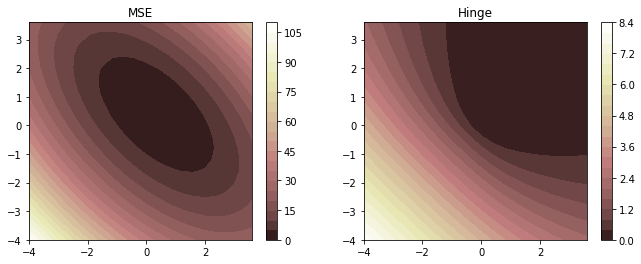

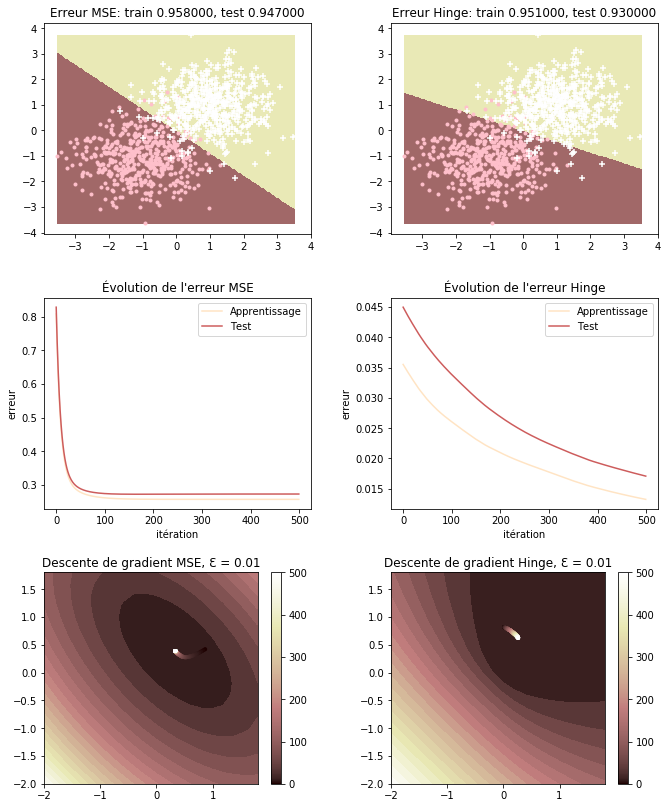

In [353]:
#/////////////////////////////////////////////////////////////////////////////////////////////// <première vague de tests> ////
    
# ··· On tente une régression sur un exemple 2D pour vérifier que le code est correct.

# Premiers pas : générer deux gaussiennes et tracer la surface de l'erreur MSE/hinge.
trainX,trainY = gen_arti(nbex=1000,data_type=0,epsilon=0.8)
testX,testY = gen_arti(nbex=1000,data_type=0,epsilon=0.8)

naiveSurfError = plt.figure(figsize=(11,4))
ax1 = naiveSurfError.add_subplot(121)
ax1.title.set_text('MSE')
ax1 = plotError(trainX,trainY,mse)
ax2 = naiveSurfError.add_subplot(122)
ax2.title.set_text('Hinge')
ax2 = plotError(trainX,trainY,hinge)

# Application à un exemple : tracé des frontières obtenues dans l’espace de représentation.
maxit=500
eps=0.01
genVisError = plt.figure(figsize=(11,14))

#//////////////////////////////// Régression linéaire ////////////////////////////////////
# Création d'un objet et processus d'entraînement.
regression = Lineaire(mse,mseG,maxit,eps)
wr = regression.fit(trainX,trainY,testX,testY) 
# Prédiction et visualisation des frontières par rapport à la répartition des données.
scoreTrain,scoreTest = regression.score(trainX,trainY),regression.score(testX,testY)
ax1 = genVisError.add_subplot(321)
ax1.title.set_text("Erreur MSE: train %f, test %f" %(scoreTrain,scoreTest))
ax1 = plotFrontiere(trainX,regression.predict,200)
ax1 = plotData(trainX,trainY) 
# Evolution de l'erreur calculée, qui diminue plus lentement au fil des itérations.
ax3 = genVisError.add_subplot(323)
ax3.title.set_text("Évolution de l'erreur MSE")
ax3.plot(regression.allossA, label = "Apprentissage",color='bisque')
ax3.plot(regression.allossT, label = "Test",color='indianred')
ax3.set(xlabel='itération',ylabel='erreur')
ax3.legend()
# Tracer la trajectoire de l'apprentissage dans l'espace des poids.
ax5 = genVisError.add_subplot(325)
ax5.title.set_text("Descente de gradient MSE, Ɛ = "+str(regression.eps))
ax5 = plotwTrace(trainX,trainY,mse,10,regression.allw)

#/////////////////////////////////// Perceptron //////////////////////////////////////////
# Création d'un objet et processus d'entraînement.
perceptron = Lineaire(hinge,hingeG,maxit,0.01)
wp = perceptron.fit(trainX,trainY,testX,testY)
# Prédiction et visualisation des frontières par rapport à la répartition des données.
scoreTrain,scoreTest = perceptron.score(trainX,trainY),perceptron.score(testX,testY)
ax2 = genVisError.add_subplot(322)
ax2.title.set_text("Erreur Hinge: train %f, test %f" %(scoreTrain,scoreTest))
ax2 = plotFrontiere(trainX,perceptron.predict,200)
ax2 = plotData(trainX,trainY) 
# Evolution de l'erreur calculée, qui diminue plus lentement au fil des itérations.
ax4 = genVisError.add_subplot(324)
ax4.title.set_text("Évolution de l'erreur Hinge")
ax4.plot(perceptron.allossA, label = "Apprentissage",color='bisque')
ax4.plot(perceptron.allossT, label = "Test",color='indianred')
ax4.set(xlabel='itération',ylabel='erreur')
ax4.legend()
# Tracer la trajectoire de l'apprentissage dans l'espace des poids.
ax6 = genVisError.add_subplot(326)
ax6.title.set_text("Descente de gradient Hinge, Ɛ = "+str(regression.eps))
ax6 = plotwTrace(trainX,trainY,hinge,10,perceptron.allw)

genVisError.subplots_adjust(wspace = 0.3, hspace=0.3)

#////////////////////////////////////////////////////////////////////////////////////////////// </première vague de tests> ////

Score : train 0.996122, test 0.990698
Score : train 1.000000, test 0.988372
Score : train 1.000000, test 0.997118
Score : train 1.000000, test 0.997118
Score : train 0.981758, test 0.976084
Score : train 0.992045, test 0.978077


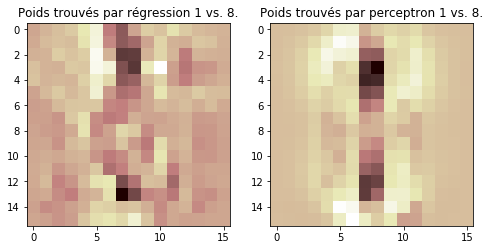

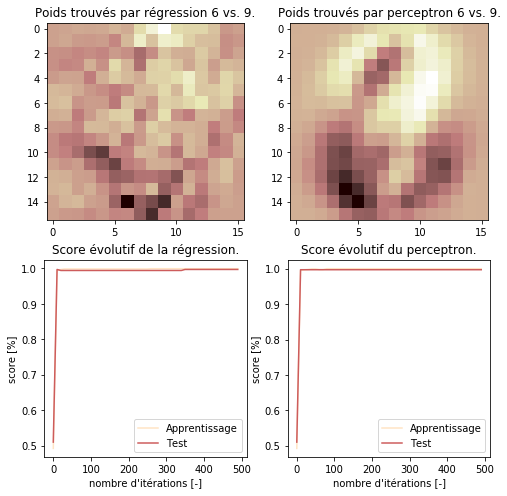

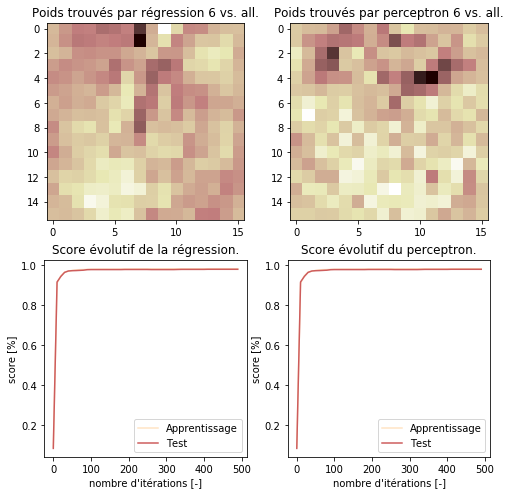

In [370]:
#/////////////////////////////////////////////////////////////////////////////////////////// <applications à la base usps> ////

# ··· Forts des vérifications précédentes, on lance des comparaisons entre les classes USPS.
# ··· Ces comparaisons peuvent se faire en 1 vs. 1, où une classe est comparée à une seule autre,
# et en 1 vs. all où l'apprentissage se fait face à tout le reste de la base.
# ··· En utilisant parallèlement la régression et le perceptron, 
# on réalise un ensemble de tests sur 1 vs. 8, 6 vs. 9 et 6 vs. all,
# en s'intéressant à chaque fois à l'évolution de l'erreur en fonction du nombre d'itérations.

dataXTrain,dataYTrain = loadUSPS("USPS/usps_train.txt")
dataXTest,dataYTest = loadUSPS("USPS/usps_test.txt")

def dataset1v1(dataX,dataY,c1,c2):
    # Extraction et labellisation des données pour comparer deux classes.
    inds = np.where((dataY==c1)|(dataY==c2))[0]
    dataX = dataX[inds]
    dataY = dataY[inds]
    dataY[dataY==c1]= -1
    dataY[dataY==c2]= 1
    return dataX, dataY

def dataset1vall(dataX,dataY,c):
    # Extraction et labellisation des données pour comparer une classe à toutes les autres.
    dataX,dataY = np.copy(dataX), np.copy(dataY)
    dataY[dataY != c] = -1
    dataY[dataY == c] = 1
    return dataX,dataY

##///////////////////////////////// Comparaison 1 vs. 8 ////////////////////////////////////
comp1to8 = plt.figure(figsize=(8,4))
xTrain, yTrain = dataset1v1(dataXTrain, dataYTrain, 1, 8)
xTest, yTest = dataset1v1(dataXTest, dataYTest, 1, 8)
# Apprentissage par régression.
regression = Lineaire(mse,mseG,max_iter=1000,eps=0.005)
wr = regression.fit(xTrain,yTrain,xTest,yTest)
scoreTrain, scoreTest = regression.score(xTrain,yTrain),regression.score(xTest,yTest)
print("Score : train %f, test %f"% (scoreTrain,scoreTest))
ax1 = comp1to8.add_subplot(121)
ax1.title.set_text("Poids trouvés par régression 1 vs. 8.")
ax1.imshow(wr.reshape(16,16), cmap=mymap)
# Apprentissage par perceptron.
perceptron = Lineaire(hinge,hingeG,max_iter=1000,eps=0.01)
wp = perceptron.fit(xTrain,yTrain,xTest,yTest)
scoreTrain, scoreTest = perceptron.score(xTrain,yTrain),perceptron.score(xTest,yTest)
print("Score : train %f, test %f"% (scoreTrain,scoreTest))
ax2 = comp1to8.add_subplot(122)
ax2.title.set_text("Poids trouvés par perceptron 1 vs. 8.")
ax2.imshow(wp.reshape(16,16), cmap=mymap)

#///////////////////////////////// Comparaison 6 vs. 9 ////////////////////////////////////
comp6to9 = plt.figure(figsize=(8,8))
xTrain, yTrain = dataset1v1(dataXTrain,dataYTrain, 6, 9)
xTest, yTest = dataset1v1(dataXTest,dataYTest, 6, 9)

# Apprentissage par régression.
regression = Lineaire(mse,mseG,max_iter=1000,eps=0.005)
wr = regression.fit(xTrain,yTrain,xTest,yTest)
scoreTrain, scoreTest = regression.score(xTrain,yTrain),regression.score(xTest,yTest)
print("Score : train %f, test %f"% (scoreTrain,scoreTest))
ax1 = comp6to9.add_subplot(221)
ax1.title.set_text("Poids trouvés par régression 6 vs. 9.")
ax1.imshow(wr.reshape(16,16), cmap=mymap)
# Etude de l'erreur.
v_train, v_test = [], []
for i in range(0,500,10):
    regression.max_iter = i
    regression.fit(xTrain,yTrain)
    v_train.append(regression.score(xTrain,yTrain))
    v_test.append(regression.score(xTest,yTest))
ax3 = comp6to9.add_subplot(223)
ax3.title.set_text("Score évolutif de la régression.")
ax3.set(xlabel="nombre d'itérations [-]",ylabel="score [%]")
ax3.plot(range(0,500,10),v_train,label ="Apprentissage",color='bisque')
ax3.plot(range(0,500,10),v_test,label ="Test",color='indianred')
ax3.legend()

# Apprentissage par perceptron.
perceptron = Lineaire(hinge,hingeG,max_iter=1000,eps=0.005)
wp = perceptron.fit(xTrain,yTrain,xTest,yTest)
scoreTrain, scoreTest = perceptron.score(xTrain,yTrain),perceptron.score(xTest,yTest)
print("Score : train %f, test %f"% (scoreTrain,scoreTest))
ax2 = comp6to9.add_subplot(222)
ax2.title.set_text("Poids trouvés par perceptron 6 vs. 9.")
ax2.imshow(wp.reshape(16,16), cmap=mymap)
# Etude de l'erreur.
v_train, v_test = [], []
for i in range(0,500,10):
    perceptron.max_iter = i
    perceptron.fit(xTrain,yTrain)
    v_train.append(perceptron.score(xTrain,yTrain))
    v_test.append(perceptron.score(xTest,yTest))
ax4 = comp6to9.add_subplot(224)
ax4.title.set_text("Score évolutif du perceptron.")
ax4.set(xlabel="nombre d'itérations [-]",ylabel="score [%]")
ax4.plot(range(0,500,10),v_train,label ="Apprentissage",color='bisque')
ax4.plot(range(0,500,10),v_test,label ="Test",color='indianred')
ax4.legend()

#//////////////////////////////// Comparaison 6 vs. all ///////////////////////////////////
comp6toall = plt.figure(figsize=(8,8))
xTrain, yTrain = dataset1vall(dataXTrain, dataYTrain, 6)
xTest, yTest = dataset1vall(dataXTest, dataYTest, 6)

# Apprentissage par régression.
regression = Lineaire(mse,mseG,max_iter=1000,eps=0.005)
wr = regression.fit(xTrain,yTrain,xTest,yTest)
scoreTrain, scoreTest = regression.score(xTrain,yTrain),regression.score(xTest,yTest)
print("Score : train %f, test %f"% (scoreTrain,scoreTest))
ax1 = comp6toall.add_subplot(221)
ax1.title.set_text("Poids trouvés par régression 6 vs. all.")
ax1.imshow(wr.reshape(16,16), cmap=mymap)
# Etude de l'erreur.
v_train, v_test = [], []
for i in range(0,500,10):
    regression.max_iter = i
    regression.fit(xTrain,yTrain)
    v_train.append(regression.score(xTrain,yTrain))
    v_test.append(regression.score(xTest,yTest))
ax3 = comp6toall.add_subplot(223)
ax3.title.set_text("Score évolutif de la régression.")
ax3.set(xlabel="nombre d'itérations [-]",ylabel="score [%]")
ax3.plot(range(0,500,10),v_train,label ="Apprentissage",color='bisque')
ax3.plot(range(0,500,10),v_test,label ="Test",color="indianred")
ax3.legend()

# Apprentissage par perceptron.
perceptron = Lineaire(hinge,hingeG,max_iter=1000,eps=0.01)
wp = perceptron.fit(xTrain,yTrain,xTest,yTest)
scoreTrain, scoreTest = perceptron.score(xTrain,yTrain),perceptron.score(xTest,yTest)
print("Score : train %f, test %f"% (scoreTrain,scoreTest))
ax2 = comp6toall.add_subplot(222)
ax2.title.set_text("Poids trouvés par perceptron 6 vs. all.")
ax2.imshow(wp.reshape(16,16), cmap=mymap)
# Etude de l'erreur.
v_train, v_test = [], []
for i in range(0,500,10):
    regression.max_iter = i
    regression.fit(xTrain,yTrain)
    v_train.append(regression.score(xTrain,yTrain))
    v_test.append(regression.score(xTest,yTest))
ax4 = comp6toall.add_subplot(224)
ax4.title.set_text("Score évolutif du perceptron.")
ax4.set(xlabel="nombre d'itérations [-]",ylabel="score [%]")
ax4.plot(range(0,500,10),v_train,label ="Apprentissage",color='bisque')
ax4.plot(range(0,500,10),v_test,label ="Test",color='indianred')
ax4.legend()

#////////////////////////////////////////////////////////////////////////////////////////// </applications à la base usps> ////

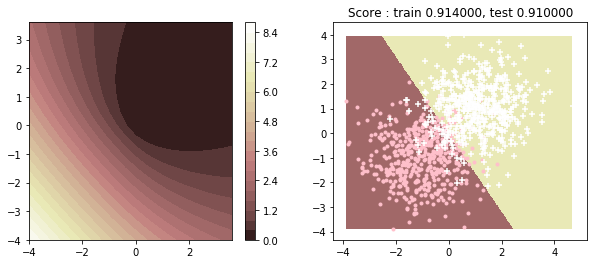

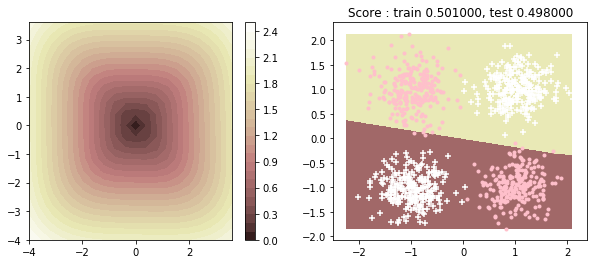

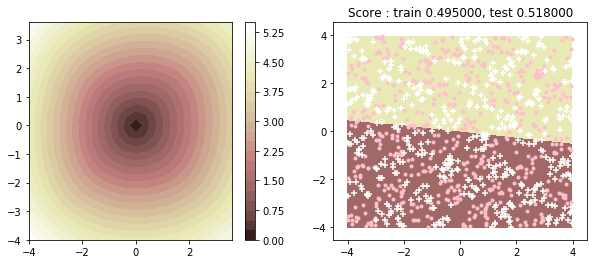

In [354]:
#////////////////////////////////////////////////////////////////////////////////////// <essais sur données artificielles> ////

# ··· On s'intéresse aux performances du perceptron basique sur un autre dataset pour en comprendre les limites.
# ··· Sur le dernier cas, les données ne sont plus linéairement séparables et l'algorithme n'est plus efficace.

def plot_gen_arti(modele=Lineaire, d_type=0, loss=hinge, loss_g=hingeG, eps=1):
    bis = plt.figure(figsize=(10,4))
    trainX,trainY = gen_arti(nbex=1000,data_type=d_type,epsilon=eps)
    testX,testY = gen_arti(nbex=1000,data_type=d_type,epsilon=eps)
    ax1 = bis.add_subplot(121)
    ax1 = plotError(trainX,trainY,loss) 
    perceptron = modele(loss,loss_g,max_iter=1000,eps=0.01)
    perceptron.fit(trainX,trainY)
    ax2 = bis.add_subplot(122)
    ax2.title.set_text("Score : train %f, test %f"% (perceptron.score(trainX,trainY),perceptron.score(testX,testY)))
    ax2 = plotFrontiere(trainX,perceptron.predict,200)
    ax2 = plotData(trainX,trainY)    

plot_gen_arti(d_type=0,eps=1)
plot_gen_arti(d_type=1,eps=0.1)
plot_gen_arti(d_type=2,eps=0.005)

#///////////////////////////////////////////////////////////////////////////////////// </essais sur données artificielles> ////

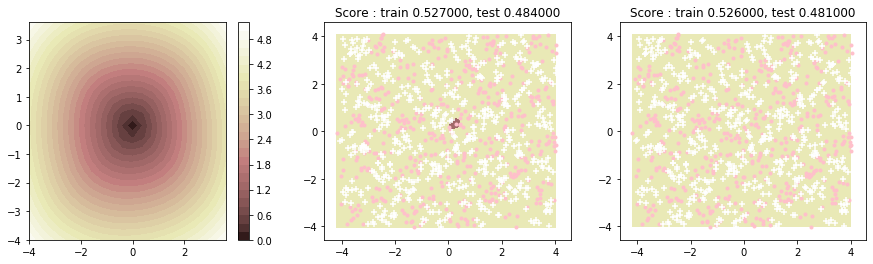

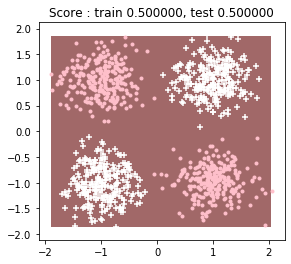

In [362]:
#/////////////////////////////////////////////////////////////////////////////////// <notion de projection et expériences> ////

# ··· La projection permet d'améliorer l’expressivité du modèle en étendant l’espace de représentation initial dans le cas 2D.
# ··· On utilise d'une part une projection quadratique, d'autre part une projection gaussienne.
# Ces deux options de projection peuvent être incluses dans une nouvelle classe de perceptrons nommée KernelTrick.
# Le but sera de les comparer.

def projection_polynomiale(dataX, dim):
    p = np.vstack((np.ones(len(dataX)),dataX[:,0],dataX[:,1],dataX[:,0]**2,dataX[:,1]**2,dataX[:,0]*dataX[:,1])).T
    return p[:,:dim]

def projectionGaussienne(dataX, grid_size=10,sigma=1,K=1):
    # Création d'une grille 2D,
    x_max = np.max(dataX)
    x_min = np.min(dataX)
    x = np.linspace(x_min,x_max,grid_size)
    pij = np.array(list(it.product(x, x)))
    # initialisation,
    s = np.zeros((len(dataX),grid_size**2))
    # puis projection pour chaque exemple.
    for i in range(len(dataX)):
        # Vecteur de taille grid_size**2
        n = np.linalg.norm(dataX[i]-pij,ord=2,axis=1) 
        s[i] = K*np.exp(-(n**2)/sigma)
    return s

class KernelTrick(Lineaire):
    # La classe se fonde sur la classe Linéaire vue plus haut. On ne répète pas les commentaires.
    def __init__(self, loss=hinge,loss_g=hingeG,max_iter=1000,eps=0.01,projection=None,dim=6,grid_size=10,sigma=1,K=1):
        self.max_iter, self.eps = max_iter,eps
        self.loss, self.loss_g = loss,loss_g
        # Détail supplémentaire, la possibilité d'une projection gaussienne ou polynomiale de dimension donnée.
        if projection == 'gauss':
            self.project,self.grid_size,self.sigma,self.K = projectionGaussienne,grid_size,sigma,K
        else: self.project,self.dim = projection_polynomiale,dim
        
    def fit(self,dataX,dataY,testX=None,testY=None):
        dataY = dataY.reshape(-1,1)
        N = len(dataY)
        if self.project == projectionGaussienne: 
            dataX = self.project(dataX,self.grid_size,self.sigma,self.K)
        else : dataX = self.project(dataX, self.dim)
        dataX = dataX.reshape(N,-1)
        D = dataX.shape[1]
        self.w = np.random.random((1,D))
        # On utilise toujours, ici, une correction sur l'ensemble de la base.
        # Et pour s'alléger, on ne garde plus d'historique.
        for i in range(self.max_iter):
            self.w -= self.eps * self.loss_g(dataX, dataY, self.w)
            
    def predict(self,dataX):
        if self.project == projectionGaussienne: 
            dataX = self.project(dataX,self.grid_size,self.sigma,self.K)
        else : dataX = self.project(dataX, self.dim)
        if len(dataX.shape)==1:
            dataX = dataX.reshape(1,-1)
        return np.sign(np.dot(dataX, self.w.T)).reshape(-1)
    
def affichage_project(loss=hinge, loss_g=hingeG, d_type=0, eps=1, dim=6, grid_size=10, sigma=1, K=1, alone=False):
    trainX,trainY = gen_arti(nbex=1000,data_type=d_type,epsilon=eps)
    testX,testY = gen_arti(nbex=1000,data_type=d_type,epsilon=eps)
    # Affichage de l'impact des projections sur des données de taille un peu plus conséquente.
    seeProjections = plt.figure(figsize=(15,4))
    if not alone:
        ax1 = seeProjections.add_subplot(131)
        ax1 = plotError(trainX,trainY,loss)
        perceptron = KernelTrick(loss,loss_g,max_iter=1000,eps=0.01,dim=dim)
        perceptron.fit(trainX,trainY)
        ax2 = seeProjections.add_subplot(132)
        ax2.title.set_text("Score : train %f, test %f"% (perceptron.score(trainX,trainY),perceptron.score(testX,testY)))
        ax2 = plotFrontiere(trainX,perceptron.predict,200)
        ax2 = plotData(trainX,trainY)
    perceptron = KernelTrick(loss,loss_g,max_iter=1000,eps=0.01,projection='gauss',grid_size=grid_size,sigma=sigma,K=K)
    perceptron.fit(trainX,trainY)
    ax3 = seeProjections.add_subplot(133)
    ax3.title.set_text("Score : train %f, test %f"% (perceptron.score(trainX,trainY),perceptron.score(testX,testY)))
    ax3 = plotFrontiere(trainX,perceptron.predict,200)
    ax3 = plotData(trainX,trainY)
        
# Comparaison des performances de la projection polynomiale (colonne 2) vs. gaussienne standard (colonne 3):    
# affichage_project(d_type=0,eps=0.1,dim=6)
# affichage_project(d_type=0,eps=0.1,dim=3)
# affichage_project(d_type=1,eps=0.1,dim=6)
affichage_project(d_type=2,eps=0.1,dim=6)

# Essais sur divers σ. 
# affichage_project(d_type=1,eps=0.1, grid_size=10, sigma=0.1, K=1, alone=True)
# affichage_project(d_type=1,eps=0.1, grid_size=10, sigma=1, K=1, alone=True)
# affichage_project(d_type=1,eps=0.1, grid_size=10, sigma=10, K=1, alone=True)
affichage_project(d_type=1,eps=0.1, grid_size=10, sigma=100, K=1, alone=True)

# Peut-on s'en sortir avec l'échiquier ?
# Normalement oui, on ne s'explique pas vraiment le résultat (surtout que les performances sont logiques sur dtype = 1)
# affichage_project(d_type=2,eps=0.1, grid_size=10, sigma=0.10, K=1, alone=True)

#////////////////////////////////////////////////////////////////////////////////// </notion de projection et expériences> ////

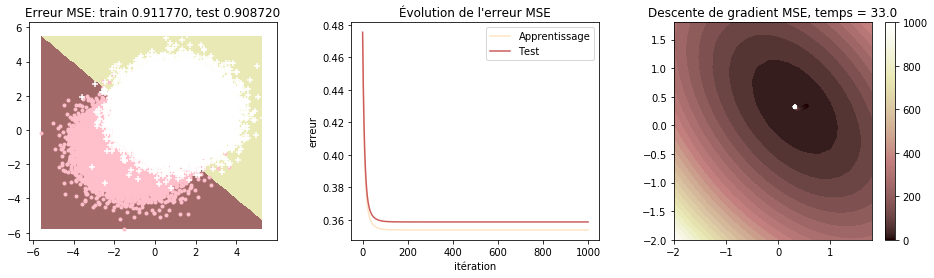

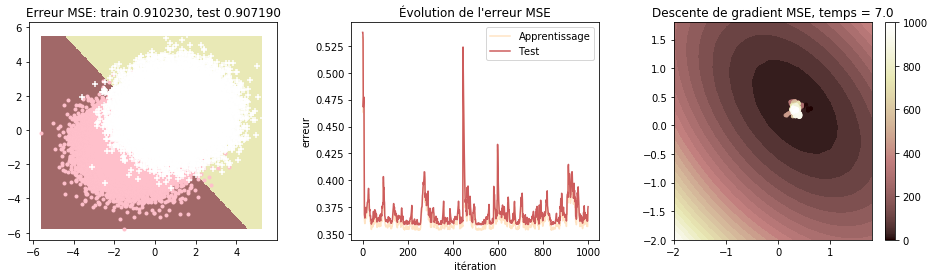

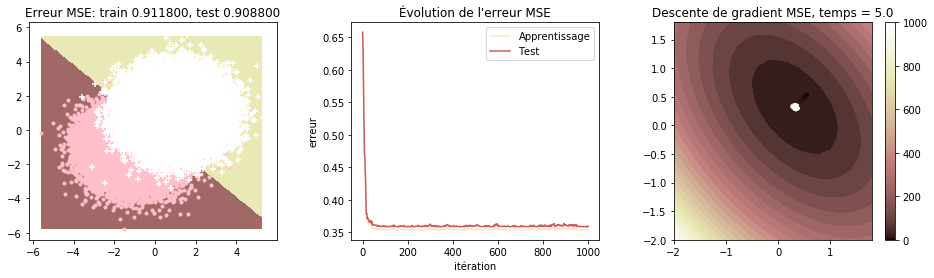

In [366]:
#///////////////////////////////////////////////////////////////////////////////////////// <bonus sur le type de descente> ////

# ··· Quel est l'impact du choix de la base pour la mise à jour des poids ?

# Géneration de deux gaussiennes assez lourdes.
trainX,trainY = gen_arti(nbex=100000,data_type=0,epsilon=1)
testX,testY = gen_arti(nbex=100000,data_type=0,epsilon=1)
data = [trainX,trainY,testX,testY]

def test_gradient(data,eps=0.01, descent="batch",batch_size=10):
    t = time.process_time()
    trainX,trainY,testX,testY = data
    maxit = 1000
    testGradient = plt.figure(figsize=(16,4))
    # Régression, apprentissage, prédiction.
    regression = Lineaire(mse,mseG,maxit,eps,descent)
    regression.fit(trainX,trainY,testX,testY) 
    scoreTrain, scoreTest = regression.score(trainX,trainY),regression.score(testX,testY)
    # Visualisation de l'erreur.
    ax1 = testGradient.add_subplot(131)
    ax1.title.set_text("Erreur MSE: train %f, test %f" %(scoreTrain,scoreTest))
    ax1 = plotFrontiere(trainX,regression.predict,200)
    ax1 = plotData(trainX,trainY) 
    # Evolution de l'erreur.
    ax2 = testGradient.add_subplot(132)
    ax2.title.set_text("Évolution de l'erreur MSE")
    ax2.plot(regression.allossA,label="Apprentissage",color='bisque')
    ax2.plot(regression.allossT,label="Test",color='indianred')
    ax2.set(xlabel='itération',ylabel='erreur')
    ax2.legend()
    # Tracé de la trajectoire de l'apprentissage dans l'espace des poids.
    ax3 = testGradient.add_subplot(133)
    ax3.title.set_text("Descente de gradient MSE, temps = "+str(np.round(time.process_time()-t)))
    ax3 = plotwTrace(trainX,trainY,mse,10,regression.allw)
    
    testGradient.subplots_adjust(wspace = 0.3, hspace=0.3)

test_gradient(data,eps=0.01, descent="batch") 
test_gradient(data,eps=0.01, descent="stochastic") 
test_gradient(data,eps=0.01, descent="mini-batch",batch_size=1000) 

#//////////////////////////////////////////////////////////////////////////////////////// </bonus sur le type de descente> ////